In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from pyspark.sql import SparkSession
from tqdm import tqdm
import time  # to simulate loading for tqdm

import os
import glob
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col, to_date, count, min, max
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.sql.functions import col, sum as spark_sum, when

# Setup Hadoop
Go to your working directory: CS611_MLE_GROUP_PROJECT <br/>
Then, run this command in your VM terminal:
> wget https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.20/gcs-connector-hadoop3-2.2.20-shaded.jar -P jars/

<br/><br/>
Copy your google cloud application_default_credentials.json to this working directory, then can run the following commands:

In [2]:
spark = SparkSession \
        .builder \
        .config("spark.jars", "jars/gcs-connector-hadoop3-2.2.20-shaded.jar") \
        .getOrCreate()

25/06/13 07:44:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
# This is required if you are using service account and set true, 
spark._jsc.hadoopConfiguration().set('fs.gs.auth.service.account.enable', 'true')
spark._jsc.hadoopConfiguration().set('google.cloud.auth.service.account.json.keyfile', "application_default_credentials.json")
# Following are required if you are using oAuth
# spark._jsc.hadoopConfiguration().set('fs.gs.auth.client.id', 'YOUR_OAUTH_CLIENT_ID')
# spark._jsc.hadoopConfiguration().set('fs.gs.auth.client.secret', 'OAUTH_SECRET')

# Load from Bronze Table

In [4]:
# ### Ingesting data from Google Cloud Storage

bucket_name = "cs611_mle"
members_path_in_bucket = "Bronze Layer/bronze_members.csv"
transactions_path_in_bucket = "Silver Layer/silver_transactions.csv"
user_logs_path_in_bucket = "Bronze Layer/df_user_logs.csv"

members_gcs_path = f"gs://{bucket_name}/{members_path_in_bucket}"
transactions_gcs_path = f"gs://{bucket_name}/{transactions_path_in_bucket}"
user_logs_gcs_path = f"gs://{bucket_name}/{user_logs_path_in_bucket}"

# Loading members
for _ in tqdm(range(1), desc="Loading members data"):
    df_members = spark.read.option("header", "true").csv(members_gcs_path)
    time.sleep(0.2)  # simulate a load delay
print("done members!")

# Loading transactions
for _ in tqdm(range(1), desc="Loading transactions data"):
    df_transaction_silver = spark.read.option("header", "true").csv(transactions_gcs_path)
    time.sleep(0.2)
print("done tx silver!")

# Loading user logs
for _ in tqdm(range(1), desc="Loading user logs data"):
    df_user_logs = spark.read.option("header", "true").csv(user_logs_gcs_path)
    time.sleep(0.2)
print("done logs!")

Loading members data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


done members!


Loading transactions data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


done tx silver!


Loading user logs data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]

done logs!


In [5]:
# df_members = pd.read_csv(r'Bronze\Bronze Layer_bronze_members.csv', index_col=0)
# df_members.index.name = None
# df_members.head()

In [6]:
# df_user_logs = pd.read_csv(r'Bronze\Bronze Layer_df_user_logs.csv', index_col=0)
# df_user_logs.index.name = None
# df_user_logs.head()

# Load from Silver Table

In [7]:
# df_transaction_silver = pd.read_csv(r'Silver\Silver Layer_silver_transactions.csv')
# df_transaction_silver.head()

# Load from Gold Table

In [8]:
# df_transaction_gold = pd.read_csv(r'Gold\Gold Layer_labels.csv')
# df_transaction_gold.head()

# EDA

### Bronze Member

In [9]:
df_members = df_members.drop('Unnamed: 0')
df_members.show(5) 

+--------------------+----+---+------+--------------+----------------------+
|                msno|city| bd|gender|registered_via|registration_init_time|
+--------------------+----+---+------+--------------+----------------------+
|2dwuk0KQUnCnRvFnD...|   5|  0|female|             9|              20120309|
|Bx13MoR+nVJVVDsat...|  13| 33|female|             7|              20130422|
|2ouWnOhbWxdFyjEy8...|   1|  0|  NULL|             7|              20140629|
|QvZtxnHz7yGh07QiF...|  13|  0|  NULL|             9|              20110528|
|CUFR22oaKwIwzj4VM...|   5| 42|  male|             9|              20141128|
+--------------------+----+---+------+--------------+----------------------+
only showing top 5 rows



In [10]:
# Convert data type
column_type_map = {
    "msno":StringType(),
    "city":IntegerType(),
    "bd":IntegerType(),
    "gender":StringType(),
    "registered_via":IntegerType()
}

for column, new_type in column_type_map.items():
    df_members = df_members.withColumn(column, col(column).cast(new_type))

df_members = df_members.withColumn(
    'registration_init_time',
    to_date(col('registration_init_time').cast('string'), 'yyyyMMdd')
)

df_members.show(5)

+--------------------+----+---+------+--------------+----------------------+
|                msno|city| bd|gender|registered_via|registration_init_time|
+--------------------+----+---+------+--------------+----------------------+
|2dwuk0KQUnCnRvFnD...|   5|  0|female|             9|            2012-03-09|
|Bx13MoR+nVJVVDsat...|  13| 33|female|             7|            2013-04-22|
|2ouWnOhbWxdFyjEy8...|   1|  0|  NULL|             7|            2014-06-29|
|QvZtxnHz7yGh07QiF...|  13|  0|  NULL|             9|            2011-05-28|
|CUFR22oaKwIwzj4VM...|   5| 42|  male|             9|            2014-11-28|
+--------------------+----+---+------+--------------+----------------------+
only showing top 5 rows



In [11]:
df_members.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df_members.columns
]).show()

[Stage 5:=========>                                                 (1 + 5) / 6]

+----+----+---+------+--------------+----------------------+
|msno|city| bd|gender|registered_via|registration_init_time|
+----+----+---+------+--------------+----------------------+
|   0|   0|  0|171532|             0|                     0|
+----+----+---+------+--------------+----------------------+



df_members consists of:
<ul>
    <li>msno = user ID, which is unique to each user and act as the primary key of this table</li>
    <li>city = city number, represented in integer</li>
    <li>gender = the gender of each user, but missing values are found</li>
    <li>registered_via = registration platform number, represented in integer</li>
    <li>registration_init_time = format %Y%m%d</li>
</ul>

In [12]:
# ============ msno =======
df_members.groupBy('msno').count().orderBy('count', ascending=False).show()

[Stage 8:=========>                                                 (1 + 5) / 6]

+--------------------+-----+
|                msno|count|
+--------------------+-----+
|56eGEJNiqLau6XF2c...|    1|
|qu8A0WStTjGumcstJ...|    1|
|FvfpM752t9Y1xhcYa...|    1|
|jjIzcIhq+Ifp5hbeo...|    1|
|kXwWZ/Y6c3caO6VMY...|    1|
|zrvS8dzTDvIV/Xmw7...|    1|
|reb2FdX8ywFLUUrvV...|    1|
|0P4OB7S70U3aRvxji...|    1|
|fGKbFFMT2OgrU1LEo...|    1|
|mvLz5BoTIrr4U3TAO...|    1|
|lTl2ZcMDz0yYNWyWc...|    1|
|MFrXvRHqDAQRs5Ds4...|    1|
|MqnwveJPAAKCrCw19...|    1|
|0tsq/0BMVC1b8Plh6...|    1|
|IqTyJXZ+F4E4NLZRF...|    1|
|uQzzyNDy4Yv5izI+J...|    1|
|FCmkX11ejjOxqPMFX...|    1|
|/mwfdTn+VnKfu7x4A...|    1|
|03IqrK+EK6PfP8FmU...|    1|
|cz2/dSALRip2azsi2...|    1|
+--------------------+-----+
only showing top 20 rows



In [13]:
# ============ city =======
city_counts = df_members.groupBy('city').count().orderBy('count', ascending=False)
city_counts.show()

+----+------+
|city| count|
+----+------+
|   1|170876|
|  13| 28413|
|   5| 23388|
|   4| 15424|
|  22| 13012|
|  15| 12703|
|   6|  7911|
|  14|  5908|
|  12|  3761|
|   9|  3049|
|  11|  2689|
|   8|  2472|
|  18|  2347|
|  10|  2080|
|  21|  1583|
|  17|  1579|
|   3|  1538|
|   7|   760|
|  16|   235|
|  20|   219|
+----+------+
only showing top 20 rows



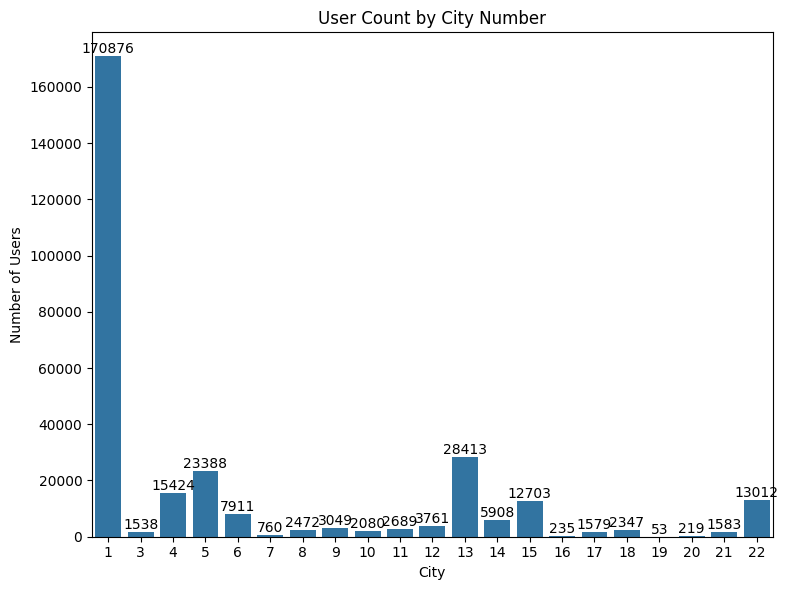

In [14]:
pd_member = df_members.toPandas()
pd_member['city'] = pd_member['city'].astype(int)

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(pd_member, x = 'city')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by City Number')
plt.xlabel('City')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Some cities has low values in number of users, bucketize low values

In [15]:
# ============ bd/age =======
df_members.groupBy('bd').count().orderBy('count', ascending=False).show()

+---+------+
| bd| count|
+---+------+
|  0|172938|
| 27|  7476|
| 26|  7041|
| 25|  6811|
| 24|  6768|
| 23|  6397|
| 28|  6303|
| 29|  6220|
| 22|  5908|
| 30|  5333|
| 21|  5026|
| 32|  4698|
| 31|  4685|
| 20|  4305|
| 33|  4272|
| 34|  3846|
| 35|  3427|
| 36|  3193|
| 19|  3192|
| 37|  3053|
+---+------+
only showing top 20 rows



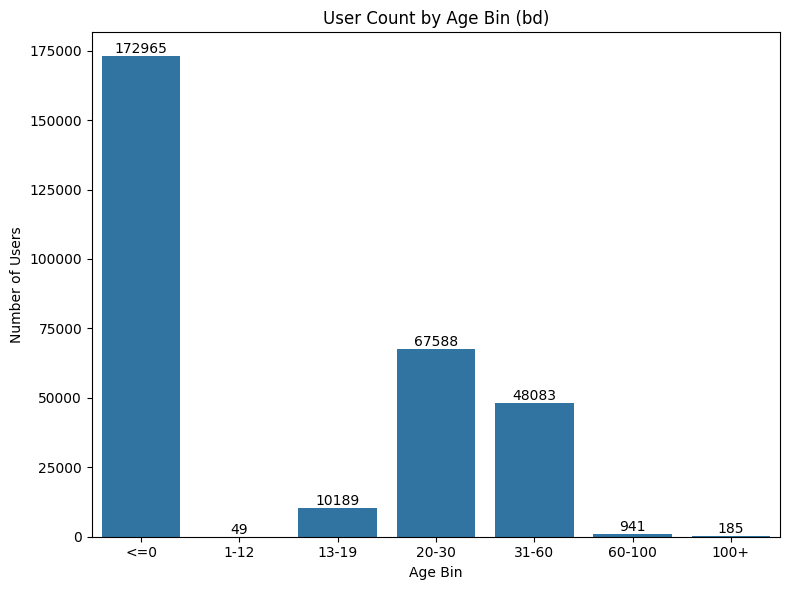

In [16]:
pd_member['bd'] = pd_member['bd'].astype(int)


bins = [-float('inf'), 0, 12, 19, 30, 60, 100, float('inf')]
labels = ['<=0', '1-12', '13-19', '20-30', '31-60', '60-100', '100+']

# Compute temporary binned Series
bd_bin = pd.cut(pd_member['bd'], bins=bins, labels=labels)

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=bd_bin, order=labels)

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by Age Bin (bd)')
plt.xlabel('Age Bin')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

In [17]:
# Drop age because it has lots of invalid data
df_members = df_members.drop('bd')
df_members.show(5)

+--------------------+----+------+--------------+----------------------+
|                msno|city|gender|registered_via|registration_init_time|
+--------------------+----+------+--------------+----------------------+
|2dwuk0KQUnCnRvFnD...|   5|female|             9|            2012-03-09|
|Bx13MoR+nVJVVDsat...|  13|female|             7|            2013-04-22|
|2ouWnOhbWxdFyjEy8...|   1|  NULL|             7|            2014-06-29|
|QvZtxnHz7yGh07QiF...|  13|  NULL|             9|            2011-05-28|
|CUFR22oaKwIwzj4VM...|   5|  male|             9|            2014-11-28|
+--------------------+----+------+--------------+----------------------+
only showing top 5 rows



In [18]:
# ============ gender ==============
df_members.select('gender').distinct().show()

+------+
|gender|
+------+
|female|
|  male|
|  NULL|
+------+



In [19]:
df_members.groupBy('gender').count().orderBy('count', ascending=False).show()

+------+------+
|gender| count|
+------+------+
|  NULL|171532|
|  male| 65635|
|female| 62833|
+------+------+



In [20]:
df_members = df_members.fillna({'gender': 'na'})
df_members.groupBy('gender').count().orderBy('count', ascending=False).show()

+------+------+
|gender| count|
+------+------+
|    na|171532|
|  male| 65635|
|female| 62833|
+------+------+



In [21]:
# ============ registered_via ============
df_members.groupBy('registered_via').count().orderBy('count', ascending=False).show()

+--------------+------+
|registered_via| count|
+--------------+------+
|             7|100050|
|             9| 75857|
|             4| 67518|
|             3| 55475|
|            11|   534|
|            13|   241|
|             8|    91|
|             5|    79|
|            17|    38|
|             2|    34|
|             6|    27|
|            16|    23|
|            19|    20|
|            14|    12|
|            10|     1|
+--------------+------+



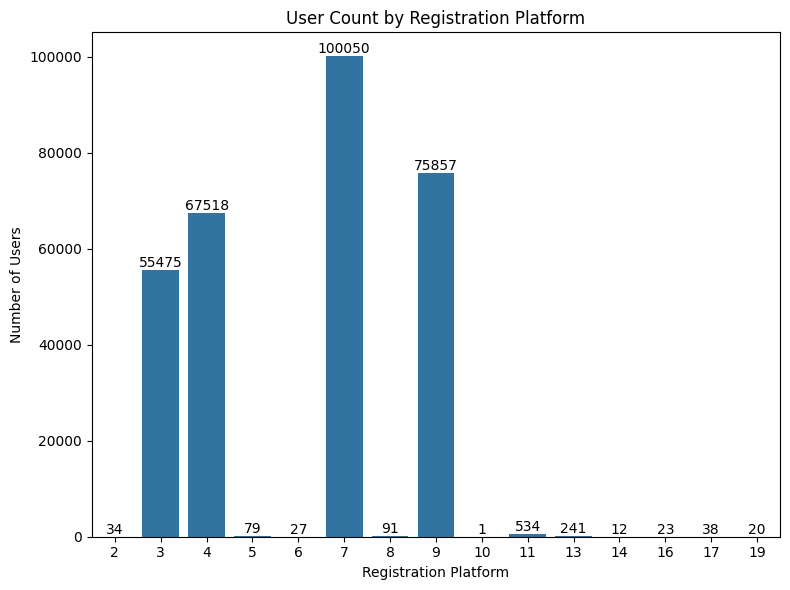

In [22]:
pd_member['registered_via'] = pd_member['registered_via'].astype(int)

# Create plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(pd_member, x = 'registered_via')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('User Count by Registration Platform')
plt.xlabel('Registration Platform')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Some platform has low values in number of users, bucketize low values

### df_user_logs

In [23]:
df_user_logs = df_user_logs.drop('Unnamed: 0')
df_user_logs.show(5)

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|mSM/P4XpWcuQUGnhL...|20150207|     0|     0|     0|      1|     54|     55| 15457.387|
|mSM/P4XpWcuQUGnhL...|20150522|    15|     0|     0|      1|      3|     14|  1227.711|
|mSM/P4XpWcuQUGnhL...|20151114|     6|     0|     0|      0|      3|      9|    782.02|
|mSM/P4XpWcuQUGnhL...|20160827|     0|     0|     2|      0|      4|      5|  1416.413|
|mSM/P4XpWcuQUGnhL...|20170225|     0|     0|     1|      0|      5|      6|  1526.661|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
only showing top 5 rows



In [24]:
# Convert data type
column_type_map = {
    "msno":StringType(),
    "num_25":IntegerType(),
    "num_50":IntegerType(),
    "num_75":IntegerType(),
    "num_985":IntegerType(),
    "num_100":IntegerType(),
    "num_unq":IntegerType(),
    "total_secs":FloatType()
}

for column, new_type in column_type_map.items():
    df_user_logs = df_user_logs.withColumn(column, col(column).cast(new_type))

df_user_logs = df_user_logs.withColumn(
    'date',
    to_date(col('date').cast('string'), 'yyyyMMdd')
)

df_user_logs.show(5)

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|mSM/P4XpWcuQUGnhL...|2015-02-07|     0|     0|     0|      1|     54|     55| 15457.387|
|mSM/P4XpWcuQUGnhL...|2015-05-22|    15|     0|     0|      1|      3|     14|  1227.711|
|mSM/P4XpWcuQUGnhL...|2015-11-14|     6|     0|     0|      0|      3|      9|    782.02|
|mSM/P4XpWcuQUGnhL...|2016-08-27|     0|     0|     2|      0|      4|      5|  1416.413|
|mSM/P4XpWcuQUGnhL...|2017-02-25|     0|     0|     1|      0|      5|      6|  1526.661|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
only showing top 5 rows



In [25]:
# ========== num_25 ===========
df_user_logs.select(
    min('num_25').alias('min'),
    max('num_25').alias('max')
).show()

+---+-----+
|min|  max|
+---+-----+
|  0|18798|
+---+-----+



In [26]:
# df_user_logs['num_25'].plot(kind='box')

In [27]:
df_user_logs.filter(col('num_25') > 12500).show()
# Outliers found
# and found high total secs 

[Stage 39:=========================================>              (11 + 4) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|rKYAG23CgaGX50gm+...|2016-01-09| 18798|   732|   688|   1504|   3616|   1118| 1494483.0|
|rKYAG23CgaGX50gm+...|2015-12-21| 16465|   626|   602|   1282|   3046|   1077| 1270916.4|
|rKYAG23CgaGX50gm+...|2015-12-31| 18733|   729|   685|   1499|   3615|   1101| 1491900.1|
+--------------------+----------+------+------+------+-------+-------+-------+----------+



In [28]:
# ========== num_50 ===========
df_user_logs.select(
    min('num_50').alias('min'),
    max('num_50').alias('max')
).show()

[Stage 40:======================================================> (39 + 1) / 40]

+---+----+
|min| max|
+---+----+
|  0|1262|
+---+----+



In [29]:
# df_user_logs['num_50'].plot(kind='box')

In [30]:
df_user_logs.filter(col('num_50') > 700).show()
# Outliers found
# and found high total secs

[Stage 46:================================================>       (13 + 2) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|UEX+mLrHrdvNVyWht...|2016-06-10|    40|   878|   157|     10|     25|   1083| 110642.67|
|rKYAG23CgaGX50gm+...|2016-01-09| 18798|   732|   688|   1504|   3616|   1118| 1494483.0|
|QNgOsoH8vYW4oG8/D...|2016-01-22|    18|   756|     1|      0|     60|     66| 37085.777|
|ekeasY63OvmQVV07d...|2016-04-04|   145|   746|    81|     15|      3|    974|  83527.66|
|mET6TKheEo/3QCyTw...|2015-12-29|   466|   760|   188|     25|      4|    937| 115769.37|
|SlhrdGRlvKRryBe+r...|2017-02-27|   581|   938|   547|     98|     64|   1792| 203545.61|
|iwzBdXs+JXTV+HNUI...|2016-08-16|   334|   702|   202|     12|      8|   1117|  95003.53|
|Yt0/tZ20o3qWMUhgm...|2016-08-27|   256|   872|    94|     11|      7|   1142| 104657.91|
|V0tc4VtZi

In [31]:
# ========== num_75 ===========
df_user_logs.select(
    min('num_75').alias('min'),
    max('num_75').alias('max')
).show()

[Stage 47:=====================================================>  (38 + 2) / 40]

+---+---+
|min|max|
+---+---+
|  0|688|
+---+---+



In [32]:
# df_user_logs['num_75'].plot(kind='box')

In [33]:
df_user_logs.filter(col('num_75') > 400).show()
# Outliers found
# and found high total secs

[Stage 53:====================================================>   (14 + 1) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|jFIwWiGrgAsFzSx8A...|2016-02-03|   115|   188|   434|    548|     31|   1246| 213323.72|
|Tz719FG9HJ7Em/ypX...|2015-10-20|    47|   109|   488|    178|     40|    758|122414.414|
|rKYAG23CgaGX50gm+...|2016-01-09| 18798|   732|   688|   1504|   3616|   1118| 1494483.0|
|KLU7vNQihy2D9Y6yl...|2016-02-13|   328|   424|   408|     40|     35|   1139| 120227.26|
|jFIwWiGrgAsFzSx8A...|2015-12-20|    84|   139|   466|    329|     10|    977| 162065.69|
|SlhrdGRlvKRryBe+r...|2017-02-27|   581|   938|   547|     98|     64|   1792| 203545.61|
|i4/GC0Jfd08UId3Lz...|2016-07-07|    56|   104|   435|    198|     16|    776| 126747.21|
|i4/GC0Jfd08UId3Lz...|2016-07-08|    80|    68|   415|    215|     23|    741| 127033.59|
|W9r/0x5PB

In [34]:
# ========== num_985 ===========
df_user_logs.select(
    min('num_985').alias('min'),
    max('num_985').alias('max')
).show()

[Stage 54:=================================================>      (35 + 5) / 40]

+---+----+
|min| max|
+---+----+
|  0|2747|
+---+----+



In [35]:
# df_user_logs['num_985'].plot(kind='box')

In [36]:
df_user_logs.filter(col('num_985') > 1600).show()
# Outliers found
# and found high total secs

[Stage 60:================================================>       (13 + 2) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|enqAew7Ekiu8s3QXl...|2016-11-28|     0|     0|     0|   2417|      6|      2|   49864.0|
|enqAew7Ekiu8s3QXl...|2016-12-02|    10|     1|     0|   2516|      9|     17| 52729.625|
|76jXST/+vmVgHwOs7...|2015-04-04|     0|     0|     0|   1617|    886|      3|  74927.42|
|76jXST/+vmVgHwOs7...|2015-02-15|     0|     0|     0|   1603|   1345|      3|  88374.06|
|76jXST/+vmVgHwOs7...|2015-04-15|     0|     0|     0|   1695|   1391|      3|  92483.99|
|76jXST/+vmVgHwOs7...|2015-02-22|     0|     0|     0|   2747|   2912|      3| 169357.12|
|76jXST/+vmVgHwOs7...|2015-02-23|     0|     0|     0|   1692|   1046|      3| 81965.484|
|76jXST/+vmVgHwOs7...|2015-03-12|     0|     0|     0|   1671|   1283|      3|  88615.59|
|76jXST/+v

In [37]:
# ========== num_100 ===========
df_user_logs.select(
    min('num_100').alias('min'),
    max('num_100').alias('max')
).show()

[Stage 61:======================================================> (39 + 1) / 40]

+---+-----+
|min|  max|
+---+-----+
|  0|20172|
+---+-----+



In [38]:
# df_user_logs['num_100'].plot(kind='box')

In [39]:

df_user_logs.filter(col('num_100') > 7500).show()
# Outliers found
# and found high total secs

[Stage 67:================================================>       (13 + 2) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|bz8tM5vSCAg992wnQ...|2016-03-22|    95|    55|    34|    450|  11213|   2272| 2708302.0|
|ZxWDBRckGEs3+L8qW...|2016-07-20|   115|    19|    15|     19|   7758|    978| 1576668.6|
|aeW+ms5r1+0LHgwkJ...|2015-12-19|     8|     8|     2|      5|   8702|     44| 1862034.5|
|jiEdYmpC+8AENimOl...|2017-01-01|     6|     0|     2|      0|  10816|     20| 2380272.0|
|foP1R+vlUmNLN7oOa...|2016-06-18|    43|     1|     0|     29|  15068|    510| 4005499.2|
|76jXST/+vmVgHwOs7...|2015-06-24|     1|     2|     5|      1|   9069|      9|  283863.6|
|eSS75Gcs1NmYjATYn...|2016-06-27|    42|    28|    21|     23|  20172|    799| 4155401.8|
|RljgFxE+iLu5nMlGK...|2016-08-03|   381|   130|   104|    121|   8421|   3025| 2051992.9|
|pLHLxfHn2

In [40]:
# ========== num_unq ===========
df_user_logs.select(
    min('num_unq').alias('min'),
    max('num_unq').alias('max')
).show()

[Stage 68:==================================================>     (36 + 4) / 40]

+---+----+
|min| max|
+---+----+
|  1|3025|
+---+----+



In [41]:
# df_user_logs['num_unq'].plot(kind='box')

In [42]:

df_user_logs.filter(col('num_unq') > 1500).show()
# Outliers found
# and found high total secs

[Stage 74:================================================>       (13 + 2) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|AkuXvmyjhg3+9bQIN...|2015-11-04|    68|    30|    13|     80|   2414|   1589| 585101.06|
|bz8tM5vSCAg992wnQ...|2016-03-22|    95|    55|    34|    450|  11213|   2272| 2708302.0|
|C23OD8bIL1ixdgT1G...|2015-02-08|  1419|   118|    25|      8|     29|   1574|  57364.91|
|CFaHdyJlruBCq4qkO...|2016-10-09|  3392|    28|    12|      7|     52|   3018| 42443.094|
|k7XqJbBHpI9owoBZZ...|2016-05-04|   140|    22|    12|     24|   2334|   1569|  606834.7|
|SlhrdGRlvKRryBe+r...|2017-02-27|   581|   938|   547|     98|     64|   1792| 203545.61|
|u0A0nM1bXT3IdnZuQ...|2016-10-10|  2680|     7|     0|      5|    173|   2823| 45011.176|
|RljgFxE+iLu5nMlGK...|2015-12-22|   175|    45|    46|     35|   3378|   1757|  812306.2|
|oqr2ReSae

In [43]:
# ========== total_secs ===========
df_user_logs.select(
    min('total_secs').alias('min'),
    max('total_secs').alias('max')
).show()

[Stage 75:======================================================> (39 + 1) / 40]

+-------------+------------+
|          min|         max|
+-------------+------------+
|-9.2233725E15|9.2233725E15|
+-------------+------------+



In [44]:
# df_user_logs['total_secs'].plot(kind='box')

In [45]:

df_user_logs.filter(col('total_secs') < 0).show()

+--------------------+----------+------+------+------+-------+-------+-------+-------------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|   total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+-------------+
|XoJGWnX0RN5ZUvUTG...|2015-04-30|     2|     6|     0|      0|    120|    118|-9.2233725E15|
|zCKbAfdXVRoZGSlmL...|2016-02-21|    12|     8|     8|      8|     53|     77|-9.2233725E15|
|YHWuzCAur0d5X82+z...|2015-07-15|    50|     6|     5|      2|     51|    101|-9.2233725E15|
|gkd3Yd+8ThL5rZJ3q...|2015-05-13|     0|     2|     0|      0|      4|      5|-9.2233725E15|
|+cWJuobnNfcWw5iVJ...|2015-07-03|     0|     0|     1|      2|     41|     44|-9.2233725E15|
|KUNZ1kAB8t125wp9w...|2015-07-08|     4|     1|     0|      0|     43|     48|-9.2233725E15|
|wqvnYhTcCaeN30b2J...|2015-10-10|    14|    10|     8|      1|    111|    135|-9.2233725E15|
|njL8nKwXtZfK6QwNK...|2015-05-25|    14|     2|     1|      0|     33|

In [46]:
# 1 day = 24 hours = 86400 seconds
df_user_logs.filter(col('total_secs') > 86400).show()

+--------------------+----------+------+------+------+-------+-------+-------+----------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+----------+
|fyEkBkwi7KQZWM1rv...|2015-02-15|     6|     2|     3|      9|     68|     87|  640794.6|
|nt1oMTJ2HZ7VSWbLT...|2016-01-20|     0|     0|     0|      0|    474|    166| 102651.51|
|FsJ87XDfjI16R8ZxT...|2015-07-05|     3|     0|     0|      0|    748|     41|  202774.6|
|i/wSrWYltgP986Ng+...|2015-07-13|    18|     6|     6|      4|    384|     79| 102633.25|
|9z/S+AAp1Ko0RBDpV...|2015-11-08|     2|     1|     0|      0|    337|    338|  86422.03|
|9z/S+AAp1Ko0RBDpV...|2016-12-27|     2|     0|     0|      0|    538|    217| 147768.88|
|lYzD69CLuDxJHD1ue...|2015-01-30|     0|     0|     0|      0|    638|    140| 154034.75|
|lYzD69CLuDxJHD1ue...|2015-03-21|     3|     0|     1|      0|    441|    394| 111167.93|
|lYzD69CLu

In [47]:

df_user_logs.filter(col('total_secs') > (0.5*10**16)).show()

[Stage 83:=========================================>              (11 + 4) / 15]

+--------------------+----------+------+------+------+-------+-------+-------+------------+
|                msno|      date|num_25|num_50|num_75|num_985|num_100|num_unq|  total_secs|
+--------------------+----------+------+------+------+-------+-------+-------+------------+
|+XCfUxc7QlExHUza/...|2015-05-07|     0|     0|     0|      0|      1|      1|9.2233725E15|
|sKpCPCQsZcap95MBq...|2015-06-09|     0|     0|     0|      0|      1|      1|9.2233725E15|
|o3D/vuZKd6cmjneaw...|2015-05-06|     0|     0|     0|      0|      1|      1|9.2233725E15|
|EYqVF700cpelgkaMa...|2015-04-24|     0|     0|     0|      0|      1|      1|9.2233725E15|
|ggjM+mdXCHxeeXYhk...|2015-10-11|     0|     0|     0|      0|    741|      1|9.2233725E15|
+--------------------+----------+------+------+------+-------+-------+-------+------------+



In [48]:
# df_user_logs[(df_user_logs['total_secs'] >= 0) & (df_user_logs['total_secs'] < (1.4*10**9))]['total_secs'].plot(kind='box')

### Transaction

In [49]:
df_transaction_silver.show(5)

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+---------------------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|membership_start_date|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+---------------------+
|++3Z+W8OPnpbHYfrK...|               41|               30|            149|               149|            1|      2015-01-08|            2015-02-09|        0|           2015-01-10|
|++3Z+W8OPnpbHYfrK...|               41|               30|            149|               149|            1|      2015-02-08|            2015-03-09|        0|           2015-02-07|
|++3Z+W8OPnpbHYfrK...|               41|               30|            149|               149|       

In [50]:
# === payment method_id ====
df_transaction_silver.groupBy('payment_method_id').count().orderBy('count', ascending=False).show()

[Stage 85:>                                                         (0 + 8) / 8]

+-----------------+-------+
|payment_method_id|  count|
+-----------------+-------+
|               41|1847550|
|               40| 523088|
|               36| 179759|
|               39| 174531|
|               37| 156567|
|               38|  85184|
|               33|  46769|
|               34|  35789|
|               35|  30873|
|               30|  23458|
|               31|  18839|
|               29|  15260|
|               27|  14280|
|               32|  13959|
|               23|   4904|
|               24|   4528|
|               28|   3955|
|               16|   3085|
|               18|   2152|
|               20|   1435|
+-----------------+-------+
only showing top 20 rows



In [51]:
pd_transaction_silver = df_transaction_silver.toPandas()

# Create plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(pd_transaction_silver, x = 'payment_method_id')

# Add count labels on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.title('Num of Transaction by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Num of Transactions')
plt.tight_layout()
plt.show()

# Some payment method has low values in number of users, bucketize low values

                                                                                
Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "RemoteBlock-temp-file-clean-thread"
Exception in thread "refresh progress" java.lang.OutOfMemoryError: Java heap space
	at scala.Option.map(Option.scala:230)
	at org.apache.spark.status.AppStatusStore.activeStages(AppStatusStore.scala:170)
	at org.apache.spark.ui.ConsoleProgressBar.org$apache$spark$ui$ConsoleProgressBar$$refresh(ConsoleProgressBar.scala:64)
	at org.apache.spark.ui.ConsoleProgressBar$$anon$1.run(ConsoleProgressBar.scala:52)
	at java.base/java.util.TimerThread.mainLoop(Timer.java:566)
	at java.base/java.util.TimerThread.run(Timer.java:516)
25/06/13 07:53:27 ERROR Utils: uncaught error in thread Spark Context Cleaner, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.invoke.DirectMethodHandle.allocateInstance(DirectMethodHandle.java:520)
	at java.base/java.lang.inv

Py4JJavaError: An error occurred while calling o39.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [ ]:
# ======== plan_list_price =============
df_transaction_silver.select(
    min('plan_list_price').alias('min'),
    max('plan_list_price').alias('max')
).show()

In [ ]:
# df_transaction_silver['plan_list_price'].plot(kind = 'box')

In [ ]:
df_transaction_silver.filter(col('plan_list_price') > 1000).show()

In [ ]:
# ======= actual_amount_paid ============

df_transaction_silver.select(
    min('actual_amount_paid').alias('min'),
    max('actual_amount_paid').alias('max')
).show()

In [ ]:
# df_transaction_silver['actual_amount_paid'].plot(kind = 'box')

In [ ]:
df_transaction_silver.filter(col('actual_amount_paid') > 1000).show()

In [ ]:
# ======= payment plan days ============
df_transaction_silver.select(
    min('payment_plan_days').alias('min'),
    max('payment_plan_days').alias('max')
).show()

In [ ]:
# df_transaction_silver['payment_plan_days'].plot(kind = 'box')

In [ ]:
# ========= is_auto_renew ===========
df_transaction_silver.select(
    min('is_auto_renew').alias('min'),
    max('is_auto_renew').alias('max')
).show()

In [ ]:
# ========= is_cancel ===========
df_transaction_silver.select(
    min('is_cancel').alias('min'),
    max('is_cancel').alias('max')
).show()

# Feature Engineering

### Transaction

In [ ]:
# Bucketize payment method id
df_transaction_silver.groupBy('payment_method_id').count().orderBy('count', ascending=False).show()

In [ ]:
valid_range = list(range(36, 42))
df_transaction_silver = (
    df_transaction_silver
        .withColumn(
            "payment_method_id",
            F.when(F.col("payment_method_id").isin(valid_range),
                   F.col("payment_method_id").cast("string"))
             .otherwise(F.lit("Others"))
        )
)

In [ ]:
df_transaction_silver.groupBy('payment_method_id').count().orderBy('count', ascending=False).show()

In [ ]:
# pd_transaction_silver = df_transaction_silver.toPandas()

# # Create plot
# plt.figure(figsize=(12, 6))
# ax = sns.countplot(pd_transaction_silver, x = 'payment_method_id')

# # Add count labels on top of bars
# for p in ax.patches:
#     count = int(p.get_height())
#     ax.annotate(f'{count}', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom', fontsize=10)

# plt.title('Num of Transaction by Payment Method')
# plt.xlabel('Payment Method')
# plt.ylabel('Num of Transactions')
# plt.tight_layout()
# plt.show()

In [ ]:
df_transaction_silver = (
    df_transaction_silver
        .withColumn(
            "discount_ratio",
            F.when(
                F.col("plan_list_price") != 0,
                (F.col("plan_list_price") - F.col("actual_amount_paid")) / F.col("plan_list_price")
            ).otherwise(F.lit(0))
        )
)

In [ ]:
df_transaction_silver.show(5)

In [72]:
# df_transaction_silver[df_transaction_silver['discount_ratio'] < 0]['is_cancel'].value_counts()

In [73]:
# df_transaction_silver[df_transaction_silver['discount_ratio'] == 1]['discount_rate'].value_counts()

In [74]:
df_transaction_silver.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,membership_start_date,discount_ratio
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-01-08,2015-02-09,0,2015-01-10,0.0
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-02-08,2015-03-09,0,2015-02-07,0.0
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-03-08,2015-04-09,0,2015-03-10,0.0
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,30,149,149,1,2015-04-08,2015-05-09,0,2015-04-09,0.0
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,41,0,0,149,1,2015-05-04,2015-06-04,1,2015-06-04,0.0


In [75]:
df_transaction_silver.to_csv('Silver Layer_silver_transactions_FE.csv', index=False)

## <b> Transaction Silver Issues to be addressed: </b>
<ol>
    <li><b>actual amount paid (or plan_list_price)</b> will be deleted later!</li>
    <li><b>payment method id</b> has been binned/bucketized, Risk of Data Leakage</li>
    <li><b>discount rate </b>= (1 - (df_transaction_silver['actual_amount_paid']/df_transaction_silver['plan_list_price'])) if df_transaction_silver['plan_list_price'] == 0 else 0<br/>but some discount rate has negative values, cause by plan_list_price < actual_amount_paid, and plan_list_price != 0</li>
        <li><b>payment_plan_days</b> some are not 30 or 31 days</li>
</ol>

### User Logs

In [76]:
df_user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-07,0,0,0,1,54,55,15457.387
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-22,15,0,0,1,3,14,1227.711
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-14,6,0,0,0,3,9,782.020
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-08-27,0,0,2,0,4,5,1416.413
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2017-02-25,0,0,1,0,5,6,1526.661


In [77]:
df_user_logs[df_user_logs['msno'] == 'mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4='].head(10).sort_values(by='date')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
84,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-07,0,0,0,1,54,55,15457.387
14348417,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-08,0,0,1,0,14,15,4250.033
22344793,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-02-10,19,1,0,0,1,19,402.101
85,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-22,15,0,0,1,3,14,1227.711
14348418,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-05-31,11,0,0,0,0,9,65.626
86,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-14,6,0,0,0,3,9,782.020
14348419,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2015-11-19,28,1,0,3,1,29,1180.717
87,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-08-27,0,0,2,0,4,5,1416.413
14348420,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2016-09-03,7,0,0,2,65,71,17871.646
88,mSM/P4XpWcuQUGnhL0vaCDEGjmM/7YaWew6O/eE5mV4=,2017-02-25,0,0,1,0,5,6,1526.661


In [78]:
# """
# each membership period
# 1. sum_songs = sum(num_25 + num_50 + num_75 + ..)
# 2. sum_total_seconds_per_day = sum(total_seconds_day1 + 2 + 3)

# 4. avg_secs_per_song = total_secs_played/sum_songs
# 5. last_first_7_days_total_secs_ratio = (total_secs_last_7_days/total_secs_first_7_days)
# 6. avg unique song played ratio (n_unique/sum_songs) per day
# 7. avg songs_played_25%_ratio = (num_25/sum_songs) per day
# 8. avg songs_played_50%_ratio = (num_50/sum_songs) per day
# 9 avg songs_played_75%_ratio = (num_75/sum_songs) per day
# 10. avg songs_played_985%_ratio = (num_985/sum_songs) per day
# 11. avg songs_played_100%_ratio = (num_100/sum_songs) per day
# 12. skip_ratio = (num_25 + num_50) / total_songs_played

# joined with tx (to get msno, start membership, expire membership)
# """

In [77]:
df_user_logs_silver = df_transaction_silver[['msno', 'membership_start_date', 'membership_expire_date']]
df_user_logs_silver.head()

,msno,membership_start_date,membership_expire_date
0,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-01-10,2015-02-09
1,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-02-07,2015-03-09
2,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-03-10,2015-04-09
3,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-04-09,2015-05-09
4,++3Z+W8OPnpbHYfrKwqRKN1bF83XEbxjdYUolhGdHZg=,2015-06-04,2015-06-04


In [79]:
df_user_logs_silver.info()

NameError: name 'df_user_logs_silver' is not defined

In [ ]:
# # Do the range join (this is like SQL's ON msno AND date BETWEEN start and end)
# df_joined = df_logs.join(
#     df_transactions,
#     on=(
#         (df_logs.msno == df_transactions.msno) &
#         (df_logs.date >= df_transactions.membership_start_date) &
#         (df_logs.date <= df_transactions.membership_expire_date)
#     ),
#     how='inner'
# )


In [ ]:
# rows = []

# for index, row in df_transaction_silver.iterrows():
#     msno = row['msno']
#     print('done msno')
#     start_date = row['membership_start_date']
#     print('start date')
#     end_date = row['membership_expire_date']
#     print('expr')

#     logs = df_user_logs[(df_user_logs['msno'] == msno) & (df_user_logs['date'] >= start_date) & (df_user_logs['date'] <= end_date)]

#     sum_songs = logs[['num_25', 'num_50', 'num_75', 'num_985', 'num_100']].sum().sum()
#     total_secs = logs['total_secs'].sum()
#     active_days = logs['date'].nunique()

#     avg_secs_per_song = total_secs / sum_songs if sum_songs > 0 else 0

#     rows.append({
#         'msno': msno,
#         'membership_start_date': start_date,
#         'membership_expire_date': end_date,
#         'sum_songs': sum_songs,
#         'total_secs': total_secs,
#         'active_days': active_days,
#         'avg_secs_per_song': avg_secs_per_song
#     })

# testing_for_df = pd.DataFrame(rows)
# testing_for_df

### Member

In [90]:
df_members.head()

,msno,city,gender,registered_via,registration_init_time
1108581,2dwuk0KQUnCnRvFnDGFyIslHLqG8lFHkyOvfRNwc5XI=,5,female,9,2012-03-09
2860696,Bx13MoR+nVJVVDsatg3fxInFupmO1jSzdkFKMA976t8=,13,female,7,2013-04-22
685587,2ouWnOhbWxdFyjEy8qx/8lr15OzZ0PX9tr6xZP4Ihns=,1,na,7,2014-06-29
3381701,QvZtxnHz7yGh07QiFuq0RN1hL5WrzcbKlQTUiroEEyE=,13,na,9,2011-05-28
5145811,CUFR22oaKwIwzj4VMey3Mj76B5zawuo2PxsWheNfQ6Q=,5,male,9,2014-11-28


In [91]:
# Account age on transaction x member registration init time